In [34]:
# Import packages
import numpy as np
import pickle
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tinydb import TinyDB
from datetime import datetime
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from matplotlib import pyplot as plt
from utils import get_lpfg_target, lorentz_estimation, read_anristu_data, interrogate_spectrum, fwhm
import seaborn as sns
from scipy import stats, optimize
from model_fcn import dropout_ensamble_prediction, get_layer_outputs, load_measured_data
import uncertainties
from uncertainties.umath import sqrt
import pandas as pd
from copy import copy
import warnings
import os

os.environ['TF_CPP_MIN_LOG_LEVEL']  = '3'
warnings.filterwarnings("ignore", category=UserWarning)

K = keras.backend

plt.rcParams['mathtext.fontset'] = 'cm' # dejavuserif
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.title_fontsize'] = 'medium'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'

# Load the measured data

Load the measured dataset (LPFG spectra) and the same spectra preprocessed by simulated FBGs

In [35]:
# Load LPFG spectra measured by the Anritsu OSA
# The keys are the wl in nm, power spectra in dBm, and transfer function in dB
with open('./data/measured_spectra.dataset', 'rb') as file:
    measured_spectra = pickle.load(file)
# Load the same spectra, simulated by random FBG arrays, for model input
# The keys are the input_strength, wl_bragg in nm, and target resonant wl in nm
# The dataset dictionary can be directly inported as below to get the whole preprocessed data
# input_strength, bragg wavelength, normalized bragg wavelength, target resonant wavelength
X, fbg_pos, fbg_norm, y = load_measured_data('./data/measured.dataset')


## Visualize some transmission spectra

Below some meassured spectra are illustrated along side the proposed interrogation system's measurement range.

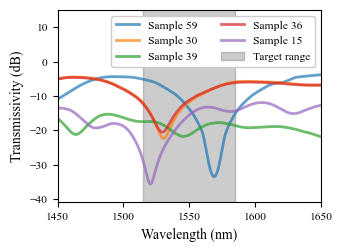

In [36]:
# Choose some random samples to plot
k = np.random.randint(0, measured_spectra['transfer_fcn'].shape[0], 5)
plt.figure(figsize=(3.4, 2.5))
min_val = 0
for i in k:
    plt.plot(measured_spectra['wl'], measured_spectra['transfer_fcn'][i], label=f'Sample {i}', lw=2, alpha=0.7)
    min_val = min(min_val, np.min(measured_spectra['transfer_fcn'][i]))
plt.fill_between([1515, 1585], -100, y2=100, 
                 color='k', alpha=0.2,
                 label='Target range')

plt.legend(ncols=2, loc='upper right')
plt.xlim(1450, 1650)
plt.ylim(np.floor(min_val-5), 15)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmissivity (dB)')
plt.show()

# Load the model

Load the LPFG decoder model and the fine tunned weights

In [37]:
# Load the model and the trained weights
model = keras.models.load_model('./ml_model/model.h5', compile=False)
model.load_weights('./ml_model/model_weights_finetunned.h5')
model.layers[-3].activation = keras.activations.softmax

# Model evaluation

## Proposed model predictions

Run the model using the measured spectra for several FBG positions.

Below one can see this models output compared to the target LPFG position.

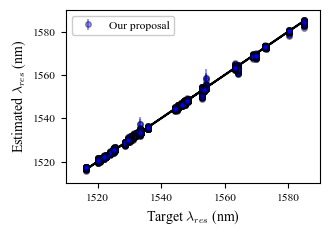

In [38]:
# Make predctions with dropout uncertainty evaluation
f_model = K.function(model.input,
                     model.output)
N = 10
predictions = dropout_ensamble_prediction(f_model, [X, fbg_pos, fbg_norm], n_iter=N)
predictions = predictions.reshape(N, len(y))
# Calculate each estimation and its uncertainty
k = stats.t.ppf(0.975, N - 1)
pred = predictions.mean(axis=0)
uncertainty = k * predictions.std(axis=0)/np.sqrt(N)

# Show response
plt.figure(figsize=(3.4, 2.5))
ms = 4
mw = 1
a = 0.4
plt.errorbar(y, pred, yerr=uncertainty, fmt='ob', alpha=a, markersize=ms, markeredgecolor='k', markeredgewidth=mw, label='Our proposal')
plt.plot(y, y, 'k')
plt.legend(loc='upper left')
plt.xlabel('Target $\lambda_{res}$ (nm)')
plt.ylabel('Estimated $\lambda_{res}$ (nm)')
plt.xlim(1510, 1590)
plt.ylim(1510, 1590)
plt.tight_layout()
plt.show()

## Base model predictions

Run the baseline model for the same samples.

Below one can see this models output compared to the target LPFG position.

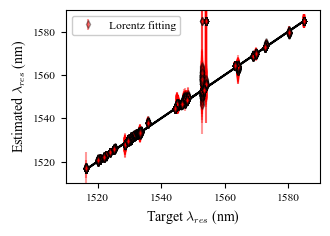

In [39]:
# Get the lorentzian approximation for each spectrum and fbg positioning
lorentz_pred = []
lorentz_uncertainty = []
for x, f in zip(X, fbg_pos):
    m, u = lorentz_estimation(f, x)
    lorentz_pred.append(m)
    lorentz_uncertainty.append(u)
lorentz_pred = np.array(lorentz_pred)
lorentz_uncertainty = np.array(lorentz_uncertainty)

# Show response
plt.figure(figsize=(3.4, 2.5))
ms = 4
mw = 1
a = 0.4
plt.errorbar(y, lorentz_pred, yerr=lorentz_uncertainty, fmt='dr', alpha=a, markersize=ms, markeredgecolor='k', markeredgewidth=mw, label='Lorentz fitting')
plt.plot(y, y, 'k')
plt.legend(loc='upper left')
plt.xlabel('Target $\lambda_{res}$ (nm)')
plt.ylabel('Estimated $\lambda_{res}$ (nm)')
plt.xlim(1510, 1590)
plt.ylim(1510, 1590)
plt.tight_layout()
plt.show()

## Comparison

We found that the proposed model performs better than the baeline model (Loretzian fitting). 

The performace improvement is more prominent for some spectra, we searched for them and tried to explain this extensive difference.

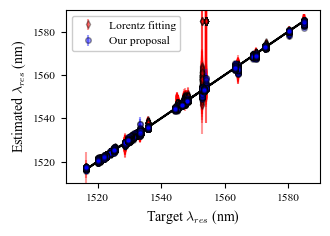

In [40]:
# Compare  the proposed model and the baseline
plt.figure(figsize=(3.4, 2.5))
ms = 4
mw = 1
a = 0.4
plt.errorbar(y, lorentz_pred, yerr=lorentz_uncertainty, fmt='dr', alpha=a, markersize=ms, markeredgecolor='k', markeredgewidth=mw, label='Lorentz fitting')
plt.errorbar(y, pred, yerr=uncertainty, fmt='ob', alpha=a, markersize=ms, markeredgecolor='k', markeredgewidth=mw, label='Our proposal')
plt.plot(y, y, 'k')
plt.legend(loc='upper left')
plt.xlabel('Target $\lambda_{res}$ (nm)')
plt.ylabel('Estimated $\lambda_{res}$ (nm)')
plt.xlim(1510, 1590)
plt.ylim(1510, 1590)
plt.tight_layout()
plt.show()

### Loretzian prediction outliers

Below one can find the spectra in which th Lorentz fitting provided a poor estimate.

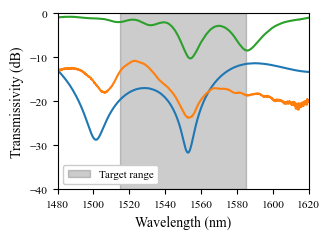

In [41]:
# Filter samples with high error
# Calculate the errors
e = y - pred
lore_e = y - lorentz_pred 
# Find the spectra where the Loretzian error is big
mask = abs(lore_e) > 5
wl_p = np.sort(np.unique(y[mask]))
# Calculate the errors
e = y - pred
lore_e = y - lorentz_pred 
# Find the spectra where the Loretzian error is big
mask = abs(lore_e) > 5
wl_p = np.sort(np.unique(y[mask]))

# Shows the problematic spectra
fig_spec = plt.figure(figsize=(3.4, 2.5))
ax_spec = fig_spec.gca()

ax_spec.fill_between([1515, 1585], -40, y2=0, 
                 color='k', alpha=0.2,
                 label='Target range')
for problem in wl_p:
    mask = measured_spectra['wl_res'] == problem
    if sum(mask) == 0:
        loc = np.argmin(abs(measured_spectra['wl_res'] - problem))
        mask[loc] = True
    ax_spec.plot(measured_spectra['wl'], measured_spectra['transfer_fcn'][mask][0], label=None)

    
ax_spec.set_xlim(1480, 1620)
ax_spec.set_ylim(-40, 0)
ax_spec.set_xlabel('Wavelength (nm)')
ax_spec.set_ylabel('Transmissivity (dB)')
ax_spec.legend(loc='lower left', framealpha=1, fontsize=8)

fig_spec.tight_layout()
plt.show()

Note that for spectra with distortions and some ripples, the Loretzian fit model had lower performance, specially when the sensor presents a second resonant wavelength outside the target interrogator range.

We believe that the incorporation of the attention mechanism could have improved this problem. This assumption was made because the attention mechanism might suppress the features related to the second resonant wavelength and other distortions, not related to the desired resonant wavlength.

## Performance metrics

Below one can find the performance metrics for both approaches, the proposed self-attention neural net and the baseline Loretzian fit.

We also restricted the dataset regarding the spectra which the Loretzian fit was to poor.

In [42]:
# Define some helper functions fro uncertain metric estimation
def rmse(y_true, y_pred, sample_uncert=True):
    """
    Calculate the Root Mean Squared Error (RMSE) between the true values and the predicted values.

    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values
    - sample_uncert: bool, optional (default=True)
        If True, calculate metric with sample uncertainty. If False, calculate metric using each uncertainty.

    Returns:
    - uncertain metric: ufloat
    """
    if sample_uncert:
        val = mean_squared_error(y_true,  y_pred, multioutput='raw_values')**0.5
        metric = np.mean(val)
        std_er = stats.t.ppf(0.975, y_true.shape[1] - 1) * np.std(val, ddof=1)/np.sqrt(y_true.shape[1])
        return uncertainties.ufloat(metric, std_er)
    else:
        res = y_true - y_pred
        metric = np.mean(res**2)
        return metric**0.5

def mape(y_true, y_pred, sample_uncert=True):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between the true values and the predicted values.

    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values
    - sample_uncert: bool, optional (default=True)
        If True, calculate metric with sample uncertainty. If False, calculate metric using each uncertainty.

    Returns:
    - uncertain metric: ufloat
    """
    if sample_uncert:
        val = 100*mean_absolute_percentage_error(y_true, y_pred, multioutput='raw_values')
        metric = np.mean(val)
        std_er = stats.t.ppf(0.975, y_true.shape[1] - 1) * np.std(val, ddof=1)/np.sqrt(y_true.shape[1])
        return uncertainties.ufloat(metric, std_er)
    else:
        res = y_true - y_pred
        metric = np.mean(np.abs(res)/y_true)
        return 100 * metric

def r2(y_true, y_pred, sample_uncert=True):
    """
    Calculate the R-squared (coefficient of determination) between the true values and the predicted values.

    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values
    - sample_uncert: bool, optional (default=True)
        If True, calculate metric with sample uncertainty. If False, calculate metric using each uncertainty.

    Returns:
    - uncertain metric: ufloat
    """
    if sample_uncert:
        val = r2_score(y_true, y_pred, multioutput='raw_values')
        metric = np.mean(val)
        std_er = stats.t.ppf(0.975, y_true.shape[1] - 1) * np.std(val, ddof=1)/np.sqrt(y_true.shape[1])
        return uncertainties.ufloat(metric, std_er)
    else:
        res = y_true - y_pred
        rss = np.sum(res**2)
        tss = np.sum((y_true - np.mean(y_true, keepdims=True))**2)
        metric = 1 - rss/tss
        return metric

In [43]:
# Create table with metrics
y_rep = np.repeat(y.reshape(1,-1), N, axis=0).T
if y_rep.shape[0] != predictions.shape[0]:
   predictions = predictions.T

lore_predictions = np.array([uncertainties.ufloat(m, u) for m, u in zip(lorentz_pred, lorentz_uncertainty)])

mask = abs(lore_e) < 5
metrics =  {  ('full dataset', 'rmse'): [rmse(y_rep, predictions), 
                                         rmse(y, lore_predictions, sample_uncert=False)],
              ('full dataset', 'mape'): [mape(y_rep, predictions), 
                                         mape(y, lore_predictions, sample_uncert=False)],
              ('full dataset', 'r2'): [r2(y_rep, predictions), 
                                       r2(y, lore_predictions, sample_uncert=False)],

              ('no outliers', 'rmse'): [rmse(y_rep[mask], predictions[mask]), 
                                        rmse(y[mask], lore_predictions[mask], sample_uncert=False)],
              ('no outliers', 'mape'): [mape(y_rep[mask], predictions[mask]), 
                                        mape(y[mask], lore_predictions[mask], sample_uncert=False)],
              ('no outliers', 'r2'): [r2(y_rep[mask], predictions[mask]), 
                                      r2(y[mask], lore_predictions[mask], sample_uncert=False)]
                                   }
df_metrics = pd.DataFrame(metrics, index=['Proposed model', 'Loretzian fitted model'])
df_metrics


full dataset                                        \
                                 rmse               mape                 r2   
Proposed model          0.738+/-0.013  0.03343+/-0.00015  0.99783+/-0.00008   
Loretzian fitted model    2.13+/-0.35    0.0500+/-0.0022      0.982+/-0.006   

                          no outliers                                        
                                 rmse               mape                 r2  
Proposed model          0.686+/-0.009  0.03207+/-0.00015  0.99814+/-0.00005  
Loretzian fitted model    0.83+/-0.04    0.0392+/-0.0015  0.99731+/-0.00027

In [44]:
# Statistical test
N = len(predictions)

for subset in ['full dataset', 'no outliers']:
    for metric in ['rmse', 'mape', 'r2']:
        proposal_m = df_metrics.loc["Proposed model", (subset, metric)].nominal_value
        proposal_s = df_metrics.loc["Proposed model", (subset, metric)].std_dev

        lorentz_m = df_metrics.loc["Loretzian fitted model", (subset, metric)].nominal_value
        lorentz_s = df_metrics.loc["Loretzian fitted model", (subset, metric)].std_dev

        # Assuming independent samples and normal distribution (use appropriate test based on your data)
        t_stat, p_value = stats.ttest_ind_from_stats(proposal_m, proposal_s, N, 
                                                     lorentz_m, lorentz_s, N) 

        print(f"Subset: {subset}, Metric: {metric}")
        print(f"T-statistic: {t_stat:.2f}")
        print(f"P-value: {p_value:.3f}")

        # Interpret the results (example)
        if p_value < 0.05:
            print(f"There is a statistically significant difference between the {metric} means.")
        else:
            print(f"There is no statistically significant difference between the {metric} means.")

Subset: full dataset, Metric: rmse
T-statistic: -337.62
P-value: 0.000
There is a statistically significant difference between the rmse means.
Subset: full dataset, Metric: mape
T-statistic: -642.14
P-value: 0.000
There is a statistically significant difference between the mape means.
Subset: full dataset, Metric: r2
T-statistic: 227.44
P-value: 0.000
There is a statistically significant difference between the r2 means.
Subset: no outliers, Metric: rmse
T-statistic: -278.41
P-value: 0.000
There is a statistically significant difference between the rmse means.
Subset: no outliers, Metric: mape
T-statistic: -400.43
P-value: 0.000
There is a statistically significant difference between the mape means.
Subset: no outliers, Metric: r2
T-statistic: 256.30
P-value: 0.000
There is a statistically significant difference between the r2 means.


# Refractive index sensor

An LPFG sensor was developed and characterized regarding RI changes using different concentrations of glycerol/water mixture.

## OSA calibration

First, the sensor was characterized using an OSA Anritsu MS9740B. The transmisson spectra was recorded in air, water and for the several RI solutions.

In [61]:
# Load the calibration dataset obtained from the OSA
with open('./data/osa_calibration.dataset', 'rb') as file:
    osa_calibration = pickle.load(file)
spectra = osa_calibration['spectra']
wl = osa_calibration['wl']
sample = osa_calibration['RI']
leg = osa_calibration['RI2sample']

### The sensor transmission

Below some spectral characteristics of the sensor used and its transmission spectra in air.

The spectral response to different glycerol/water mixtures are also provided.

Insertion loss: -4.33 dB
Attenuation: 15.45 dB
FWHM: 52.92 nm


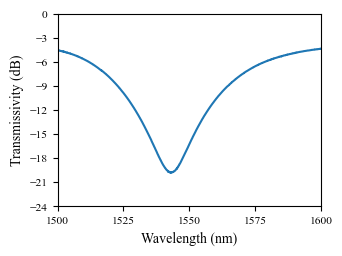

In [62]:
# Sensor characteristics
il = max(spectra[0])
att = max(spectra[0]) - min(spectra[0])
fwhm_lpg = fwhm(wl, spectra[0])

print(f'Insertion loss: {il:.2f} dB')
print(f'Attenuation: {att:.2f} dB')
print(f'FWHM: {fwhm_lpg:.2f} nm')

plt.figure(figsize=(3.4, 2.5))
plt.plot(wl, spectra[0], label='LPFG in air', zorder=-1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmissivity (dB)')
plt.yticks(np.arange(-24, 1, 3))
plt.xticks(np.arange(1500, 1601, 25))
plt.xlim(1500, 1600)

plt.show()

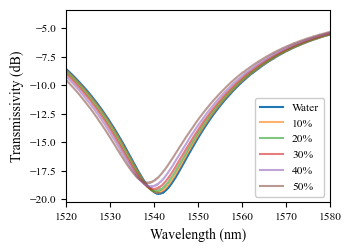

In [63]:
# Sensor spectrum due to RI change
plt.figure(figsize=(3.4, 2.5))
wl_res = []
wl_res_u = []
plot_water = True
for sample_name, spectrum in zip(sample, spectra):
    if sample_name != sample[0] and sample_name != sample[1]:
        plt.plot(wl, spectrum, label=leg[sample_name], alpha=0.6)
    if (plot_water and sample_name == sample[1]):
        plt.plot(wl, spectrum, label=leg[sample_name])
    if sample_name == sample[1]:
        plot_water = False
    estimation, err = interrogate_spectrum(wl*1e-9, spectrum, return_err=True)
    wl_res.append(estimation)
    wl_res_u.append(err) 
wl_res = np.array(wl_res)
wl_res_u = np.array(wl_res_u)

plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmissivity (dB)')
plt.xlim(1520, 1580)
plt.show()

### Calibration curve

Calibrate the resonant wavelength regarding the shift from the water sample. This is done to improve temperature crosssenstivity.

In [64]:
# Organize data
calibration_osa = pd.DataFrame({'Sample': sample, 'wl_res': wl_res, 'wl_res_err': wl_res_u })[1::]

mask = calibration_osa['Sample'] == calibration_osa['Sample'].values[0]
mask = mask.values
calibration_osa.iloc[mask, 2] = 2*np.std(calibration_osa.iloc[mask, 1].values)
calibration_osa.iloc[mask, 1] = np.mean(calibration_osa.iloc[mask, 1].values)

dwl = -5.80e+02 n^2 + 1.54e+03 n + -1.02e+03
Uncertainty in the coefficients: [ 69.31138525 188.42544222 128.02930423]


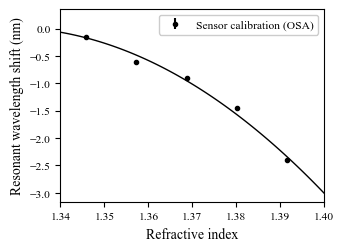

In [65]:
# Show calibration curve

plt.figure(figsize=(3.4, 2.5))

x, y = calibration_osa['Sample'], calibration_osa['wl_res']-calibration_osa['wl_res'].values[0]
p, cov = np.polyfit(x, y, 2, cov=True)
print(f'dwl = {p[0]:.2e} n^2 + {p[1]:.2e} n + {p[2]:.2e}')
print(f'Uncertainty in the coefficients: {np.sqrt(np.diag(cov))}')
plt.errorbar(calibration_osa['Sample'], calibration_osa['wl_res']-calibration_osa['wl_res'].values[0], yerr=calibration_osa['wl_res_err'], fmt='.k', label='Sensor calibration (OSA)')
plt.plot(np.linspace(1.34, 1.4, 100), np.polyval(p, np.linspace(1.34, 1.4, 100)), 'k', lw=1, label=None)

plt.xlabel('Refractive index')
plt.ylabel('Resonant wavelength shift (nm)')
plt.xlim(1.34, 1.4)
plt.legend()
plt.show()

In [66]:
# Helper function to estimate RI from the resonant wavelength shift
def invert_function(delta_wl, p, cov=None):
    """
    A helper function to invert the polynomial fit to obtain the refractive index based on the resonant wavelength shift.

    Parameters:
    delta_wl (float): The wavelength shift.
    p (tuple): A tuple containing the coefficients of the polynomial fit.
    cov (array-like): The covariance matrix of the polynomial fit.

    Returns:
    float: The calculated refractive index.
    """
    a, b, c = p
    if cov is None:
        return (-b - (b**2 - 4*a*(c-delta_wl))**0.5)/(2*a)
    else:
        a, b, c = uncertainties.ufloat(a, cov[0, 0]**0.5), uncertainties.ufloat(b, cov[1, 1]**0.5), uncertainties.ufloat(c, cov[2, 2]**0.5)
        return (-b - (b**2 - 4*a*(c-delta_wl))**0.5)/(2*a)

## Measurements using the proposed model

A system was developed to acquire the reflection spectra read by BraggMeter. It extracted the bragg positions and peak intensities, then implemented the proposed interrogation model to estimate the LPFG position. All data was recorded in a database using TinyDB.

Below the measurements time series is shown, with sample alternance. The difference between the water sample used before the RI sample was considered for RI estimation.

In [67]:
# Read the database
database = TinyDB('./data/lpfg1_realtime.json')
# The measurements are stored in the 'measurements' table
df_braggmeter = pd.DataFrame(database.table('measurements_2024-06-20 16:34:18').all())
time, prediction = df_braggmeter['time'], df_braggmeter['prediction']
time = np.array([datetime.strptime(date, "%Y-%m-%d %H:%M:%S") for date in time])
# Select the interval where sensor was settled
times_series_parts = [[0, 12, 37], [10, 45, 70], 
                      [0, 75, 90], [20, 93, 108], 
                      [0, 112, 125], [30, 130, 142],
                      [0, 146, 163], [40, 168, 177],
                      [0, 180, 200], [50, 205, 222],
                      [0, 225, 239]]

elapsed = time - time[10]
elapsed = np.array([e.seconds for e in elapsed])

In [68]:
# Store each part of the time series in a list
sample = []
wl_res = []
wl_res_u = []
sample2ri = {0: 1.3344272, 10: 1.3458604, 20: 1.3572936,
             30: 1.3687268, 40: 1.38016, 50: 1.3915932}

for each in times_series_parts:
    wl_res.append(np.mean(prediction[each[1]:each[2]]))
    wl_res_u.append(2*np.std(prediction[each[1]:each[2]], ddof=1)/np.sqrt(len(prediction[each[1]:each[2]])-1))
    sample.append(sample2ri[each[0]])

10%: 1540.01 $\pm$ 0.02
20%: 1539.67 $\pm$ 0.03
30%: 1539.34 $\pm$ 0.01
40%: 1538.71 $\pm$ 0.01
50%: 1538.04 $\pm$ 0.01


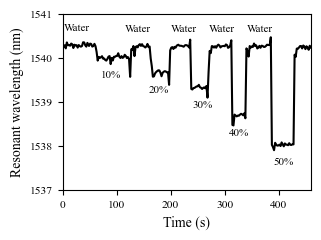

In [69]:
# Show LPFG sensor response in time
plt.figure(figsize=(3.4, 2.5))

plt.plot(elapsed[10::], prediction[10::], '-k', label=None)
plt.ylim(1537, 1541)
plt.xlim(0, 460)
plt.ylabel('Resonant wavelength (nm)')
plt.xlabel('Time (s)')

texts = [[3, 'Water'],
         [70, '10%'],
         [115, 'Water'],
         [160, '20%'],
         [200, 'Water'],
         [240, '30%'],
         [270, 'Water'],
         [307, '40%'],
         [340, 'Water'],
         [390, '50%']]

wlres, uncert = np.round(wl_res, decimals=2), np.round(wl_res_u, decimals=2)
for wl_res_i, unce_i, text, x_pos in zip(wlres, uncert, texts, times_series_parts):
    #text[0] = np.mean(elapsed[x_pos[1::]])
    
    if text[1] == 'Water':
        delta = +0.4
        wl_text = f'{wl_res_i} $\pm$ {unce_i}'
    else:
        delta = -0.4
        wl_text = f'{wl_res_i} $\pm$ {unce_i}'
        print(f'{text[1]}: {wl_text}')
    plt.text(text[0], wl_res_i+delta, 
             text[1], fontsize=8,
             ha='left', va='center', rotation=0)
    
    
plt.tight_layout()
plt.show()

Using the calibration curve, we could estimate the sample RI using the proposed interrogation method:

In [70]:
# Estimate RI
wl_res_u = np.array([uncertainties.ufloat(m, u) for m, u in zip(wl_res, uncert)])
dwl = wl_res_u[1::2] - wl_res_u[0:-1:2]
estimated_ri = invert_function(dwl, p)

print(f'Estimated RI: {[ei for ei in estimated_ri]}')

Estimated RI: [1.3506403713922608+/-0.0010666223754118578, 1.3602877567416232+/-0.0011250791398116462, 1.368355259183752+/-0.000475062095087122, 1.3798669025522599+/-0.0003700639593616548, 1.3898205176353404+/-0.00043938103969933033]


Below we estimate each sample actual RI. We used an Abbe refractometer with Brix scale, so the scale should be transformed to RIU. Moreover, the 40% and 50% concentrartions were outside the refractometer range, so we extrapolated the values using linear fit.

The concentration to brix curve is:

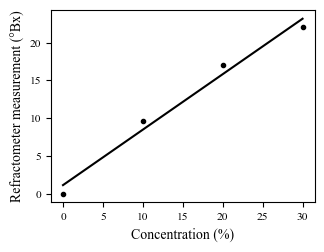

In [71]:
# Calculate the sample RI
# A abbe refractometer was used to measure the refractive index of the samples, however in brix scale
brix2ri_table = pd.read_excel('./data/brix2ri.xlsx')
brix_measurements = [uncertainties.ufloat(0, 0), 
                    uncertainties.ufloat(9.6, 0.2), 
                    uncertainties.ufloat(17, 0.2), 
                    uncertainties.ufloat(22, 0.2)]
percent = [0, 10, 20, 30]
# Fit a curve to estimate the brix of the samples outside the refractometer range
p, cov = np.polyfit(percent, [brix.nominal_value for brix in brix_measurements], 1, cov=True)

plt.figure(figsize=(3.4, 2.5))
plt.plot(percent, [brix.nominal_value for brix in brix_measurements], '.k')
plt.plot(np.linspace(0, 30, 5), np.polyval(p, np.linspace(0, 30, 5)), 'k')
plt.xlabel('Concentration (%)')
plt.ylabel('Refractometer measurement (°Bx)')
plt.show()

p = [uncertainties.ufloat(p[0], cov[0, 0]**0.5), uncertainties.ufloat(p[1], cov[1, 1]**0.5)]
brix_measurements.extend((p[0]*np.linspace(40, 50, 2)+p[1]).tolist())
percent.extend([40, 50])

Hence, the sample RI were:

In [72]:
p, cov = np.polyfit(brix2ri_table['Brix'], brix2ri_table['Refractive index'], 1, cov=True)
p = [uncertainties.ufloat(p[0], cov[0, 0]**0.5), uncertainties.ufloat(p[1], cov[1, 1]**0.5)]
ri = np.polyval(p, [brix.nominal_value for brix in brix_measurements])
sample_ri = {sample: ri_i.format('f') for sample, ri_i in zip(percent, ri)}
print(f'Sample RI\n {sample_ri}')

Sample RI
 {0: '1.33211+/-0.00016', 10: '1.34751+/-0.00018', 20: '1.35938+/-0.00022', 30: '1.36740+/-0.00026', 40: '1.38103+/-0.00032', 50: '1.3928+/-0.0004'}


Given the estimated RI and the sample RI, we could calculate the RI errors:

In [73]:
# Estimate RI bias and standard error
estimated_ri_m = np.array([ei.nominal_value for ei in estimated_ri])
ri = np.array([ei.nominal_value for ei in ri])
ri = ri[1::]
err = ri - estimated_ri_m
p_err = (err)/ri

bias, se = np.mean(err), np.std(err, ddof=1)/np.sqrt(len(err))

print(f'RI perc err: {100*np.mean(p_err):.2e}%')
print(f'RI bias: {bias:.2e}')
print(f'RI standard error: {se:.2e}')


RI perc err: -1.40e-02%
RI bias: -1.68e-04
RI standard error: 1.04e-03


Comparing the sample RI with the estimated RI we could note that most error occurs for lower RI, where the sensitivity is smaller.

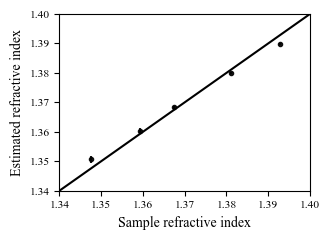

In [74]:
# Plot comparison
plt.figure(figsize=(3.4, 2.5))
plt.errorbar(ri, [ei.nominal_value for ei in estimated_ri], 
            yerr=[ei.s for ei in estimated_ri], fmt='.k', alpha=0.9)
plt.plot([1.34, 1.4], [1.34, 1.4], 'k')
plt.xlim(1.34, 1.4)
plt.ylim(1.34, 1.4)
plt.xlabel('Sample refractive index')
plt.ylabel('Estimated refractive index')
plt.tight_layout()
plt.show()